In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
adata = sc.read_h5ad('../../data/from_spatial_omics/MERFISH/MERFISH_Fang2022Conservation_H18.06.006.MTG.250.expand.rep1_data.h5ad')

In [3]:
adata.X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
adata.layers['counts'] = adata.X.copy()

In [5]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=100)

In [6]:
adata

AnnData object with n_obs × n_vars = 9259 × 247
    obs: 'name', 'global.x', 'global.y', 'adjusted.x', 'adjusted.y', 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'n_counts', 'leiden', 'n_genes'
    var: 'n_cells'
    uns: 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

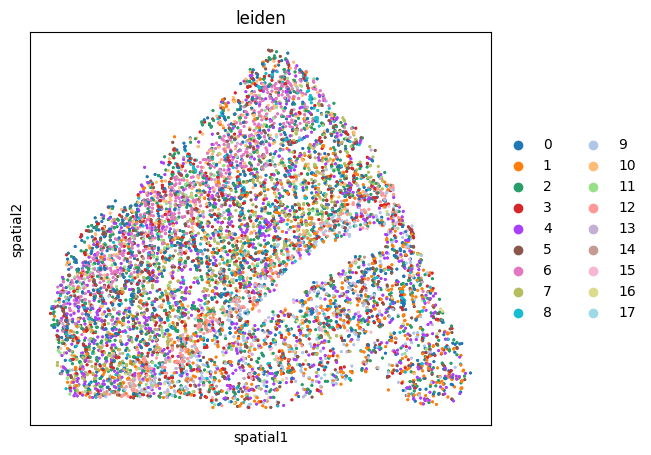

In [7]:
sq.pl.spatial_scatter(adata, color=['leiden'], size=5, shape=None)

In [8]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('mt-')]
adata = adata[:, non_mito_genes_list]

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=10, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:08<00:00, 11.35/s]


In [11]:
adata.uns['moranI']

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
STMN2,0.243733,0.000000,0.000037,0.000000,0.009901,0.000037,0.000000,0.000000,0.010064
IGFBP5,0.225107,0.000000,0.000037,0.000000,0.009901,0.000033,0.000000,0.000000,0.010064
LAMP5,0.223811,0.000000,0.000037,0.000000,0.009901,0.000028,0.000000,0.000000,0.010064
OLFM1,0.207875,0.000000,0.000037,0.000000,0.009901,0.000032,0.000000,0.000000,0.010064
CLSTN2,0.177453,0.000000,0.000037,0.000000,0.009901,0.000036,0.000000,0.000000,0.010064
...,...,...,...,...,...,...,...,...,...
TSIX,0.013874,0.010765,0.000037,0.001989,0.019802,0.000023,0.010942,0.002014,0.020045
ADAMTSL1,0.011790,0.025232,0.000037,0.000977,0.009901,0.000015,0.025543,0.000993,0.010064
ADAM12,0.009853,0.050760,0.000037,0.016928,0.029703,0.000019,0.051174,0.017066,0.029945
SLC22A25,0.007777,0.097447,0.000037,0.060230,0.108911,0.000021,0.097843,0.060475,0.109354


In [12]:
n_svgs = 25
sel_genes = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(n_svgs).index.tolist()
)

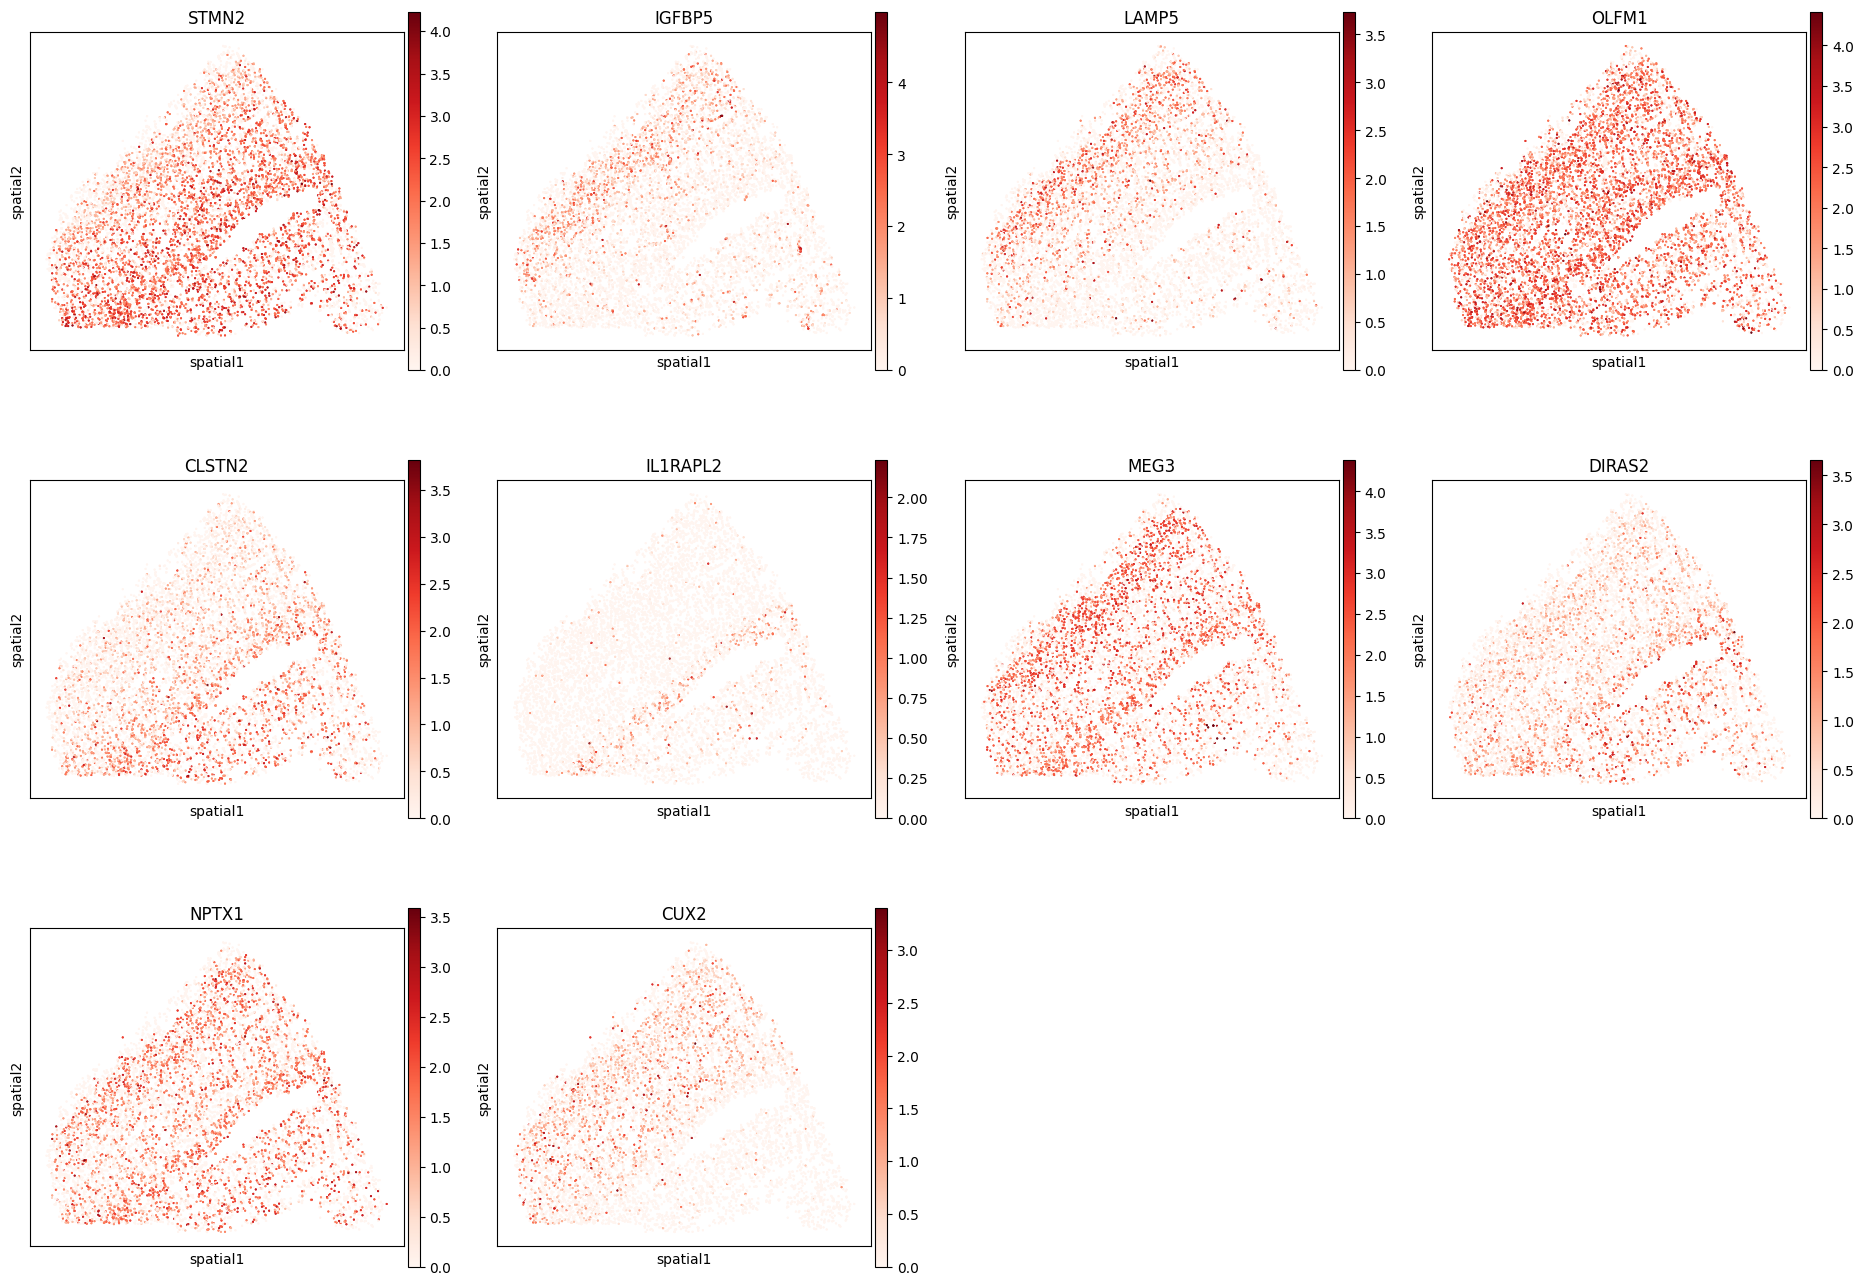

In [13]:
sq.pl.spatial_scatter(
    adata, color=sel_genes[:10], figsize=(5, 5), size=1, 
    cmap="Reds", shape=None, use_raw=False
)

In [14]:
# select top 50 variable genes as reference
adata = adata[:, sel_genes]

In [15]:
adata

View of AnnData object with n_obs × n_vars = 9259 × 25
    obs: 'name', 'global.x', 'global.y', 'adjusted.x', 'adjusted.y', 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'n_counts', 'leiden', 'n_genes'
    var: 'n_cells'
    uns: 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [16]:
adata.write_h5ad('../../results/00_prepare_reference_data/34_MERFISH_Human_cortex.h5ad')